# Pipeline for High-z Radio Galaxies 14: SHAP values for base models for selected sources

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the base-learners used for predictions.  
It is possible to select either a random sample from the predicted pipeline (non-star, radio AGN) or high-redshift sources,  
regardless of their predicted values.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

In [4]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_calibration     = True
use_high_z_sources  = True  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [5]:
used_area          = 'HETDEX'  # can be 'S82', 'HETDEX'
HETDEX_subset      = 'all'  # Validation, Training, Test, Test_Train
subset_str         = ''

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]
cols_2_use          = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'zsp', 'spCl', 'band_num', 'LOFAR_detect', 
                       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Speak_LOFAR', 'rms_LOFAR', 'Sint_LOFAR_non_imp', 
                       'Sint_LOFAR_AB_non_imp', 'Speak_LOFAR_non_imp', 'is_str', 'is_SDSS_QSO', 'is_AGN', 
                       'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 
                       'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 
                       'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 
                       'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 
                       'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 
                       'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 
                       'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 
                       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']

In [8]:
full_catalog_df     = pd.read_parquet(gv.cat_path + file_name.replace('h5', 'parquet'), engine='fastparquet', columns=cols_2_use)

In [9]:
full_catalog_df.columns

Index(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'zsp', 'spCl', 'band_num',
       'LOFAR_detect', 'Sint_LOFAR', 'Sint_LOFAR_AB', 'Speak_LOFAR',
       'rms_LOFAR', 'Sint_LOFAR_non_imp', 'Sint_LOFAR_AB_non_imp',
       'Speak_LOFAR_non_imp', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal',
       'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag',
       'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z',
       'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i',
       'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4',
       'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4',
       'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J',
       'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1',
       'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1',
       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4',
       'W3_W4'],
      dtype='o

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_confirmed, 'class'] = np.nan
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [11]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

#### Select relevant sources

For instance, select only AGN, only radio-AGN, X-ray AGN, high-z sources, etc.

In [12]:
# filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_selection   = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('X') == True)
# filter_selection   = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
full_catalog_df    = full_catalog_df.loc[filter_selection]
high_z_str         = '_filtered'

In [13]:
len(full_catalog_df)

3724

Select depending on radio detection

In [14]:
filter_A = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('R') == True)  # Fewer elements than in B
filter_B = ~filter_A

In [15]:
# filter_A = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('Q') == True) | np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('A') == True)  # Fewer elements in B
# filter_B = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('K') == True) | np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('N') == True)

In [16]:
sample_size = np.min([np.sum(filter_A), np.sum(filter_B)])

In [17]:
subset_A = full_catalog_df.loc[filter_A].sample(n=sample_size, random_state=gv.seed)
subset_B = full_catalog_df.loc[filter_B].sample(n=sample_size, random_state=gv.seed)

In [18]:
print(len(subset_A))
print(len(subset_B))

344
344


In [19]:
full_catalog_df = pd.concat([subset_A, subset_B])

In [123]:
full_catalog_df.loc[:, 'TYPE']

index
7787979      NRX
6599481      QRX
9424378     QR2X
8692345      QRX
14356871    BR2X
            ... 
2008594       QX
14361422      QX
14409064      QX
12437708      QX
1568235       QX
Name: TYPE, Length: 688, dtype: object

In [20]:
highlight_filter_A     = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('R') == True)
highlight_filter_B     = ~highlight_filter_A
# highlight_filter_A     = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('Q') == True) | np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('A') == True)
# highlight_filter_B     = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('K') == True) | np.array(full_catalog_df.loc[:, 'TYPE'].str.contains('N') == True)
highlight_filter_LOFAR = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

In [21]:
full_catalog_df          = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [22]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')
print(f'From them, {np.sum(full_catalog_df.loc[:, "class"] == 1)} are confirmed AGN.')
print(f'From all the sources, {np.sum(full_catalog_df.loc[:, "LOFAR_detect"] == 1)} have radio (LOFAR-like) detection.')
print(f'From the {np.sum(full_catalog_df.loc[:, "class"] == 1)} AGN,\
 {np.sum((full_catalog_df.loc[:, "class"] == 1) & (full_catalog_df.loc[:, "LOFAR_detect"] == 1))} have radio (LOFAR-like) detection.')

Full used dataset size:              (688, 97)
--------------------------------------------------
Thus, it has 688 sources and 97 features.
From them, 688 are confirmed AGN.
From all the sources, 236 have radio (LOFAR-like) detection.
From the 688 AGN, 236 have radio (LOFAR-like) detection.


### Load models

In [23]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [24]:
threshold_AGN_logit      = np.log(gv.AGN_thresh   / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

#### Predictions

In [25]:
full_catalog_df['pred_star']     = 0
full_catalog_df['Score_no_star'] = 1

In [26]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [27]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [28]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [29]:
redshift_tol    = 0.0

In [30]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on sub-set of base learners.

In [31]:
run_shap_AGN_base    = True
run_shap_radio_base  = True
run_shap_z_base      = True

In [32]:
filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [33]:
if run_shap_AGN_base:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [34]:
if run_shap_AGN_base:
    # sample_size_AGN  = 2000
    sub_size_AGN     = len(full_catalog_df)
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 688


In [35]:
if run_shap_AGN_base:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [36]:
if run_shap_AGN_base:
    reduced_data_AGN    = full_catalog_df.loc[filter_pred_no_str].sample(n=sub_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns.drop(base_models_names_AGN)

class  pred_class
count  688.0  688.000000
mean     1.0    0.950581
std      0.0    0.216898
min      1.0    0.000000
25%      1.0    1.000000
50%      1.0    1.000000
75%      1.0    1.000000
max      1.0    1.000000

Use FastTreeSHAP package

In [37]:
if run_shap_AGN_base:
    explainers_AGN_base = {}
    for model, model_fit in zip(AGN_gal_clf.named_steps['trained_model'].estimators, AGN_gal_clf.named_steps['trained_model'].estimators_):
        explainers_AGN_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',
                                                                   model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                   n_jobs=12)  # No data

In [38]:
if run_shap_AGN_base:
    shap_values_AGN_base  = {}
    for model in explainers_AGN_base.keys():
        print(f'Working with base model {model}')
        shap_values_AGN_base[model] = explainers_AGN_base[model](reduced_data_AGN_df.drop(columns=base_models_names_AGN), check_additivity=False)

Working with base model xgboost
Working with base model rf
Working with base model et
Working with base model gbc


In [39]:
if run_shap_AGN_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_AGN_base.keys():
        expected_value = np.array([explainers_AGN_base[model].expected_value]).flatten()[-1]
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            print(f'{model: <10}\t: {np.exp(expected_value) / (1 + np.exp(expected_value)): .4f}')
        else:
            print(f'{model: <10}\t: {expected_value: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	:  0.3623
rf        	:  0.4260
et        	:  0.4256
gbc       	:  0.3240


In [112]:
if run_shap_AGN_base:
    AGN_ordered_feat_lists = {}

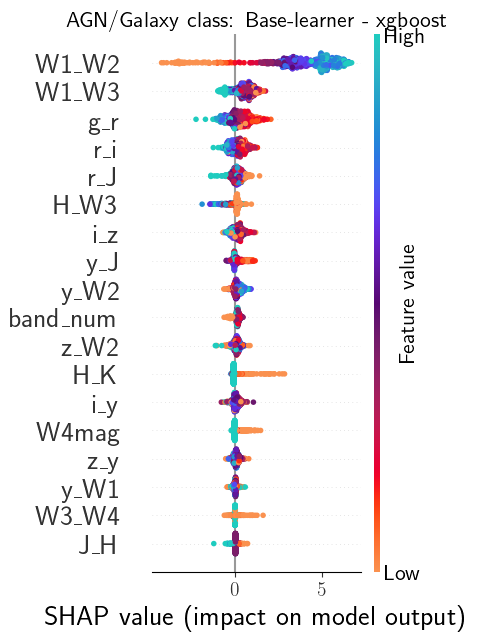

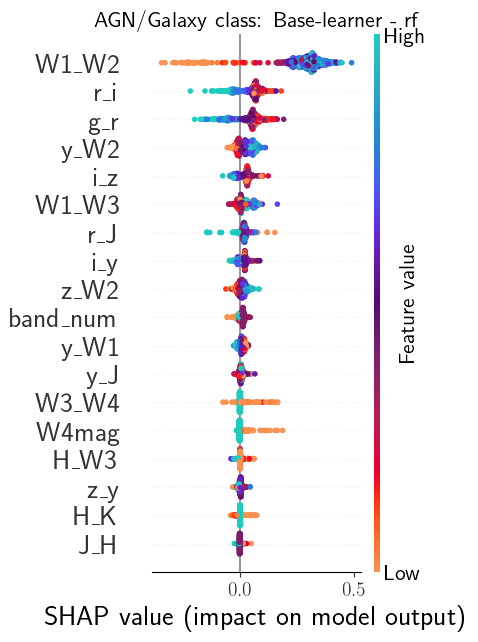

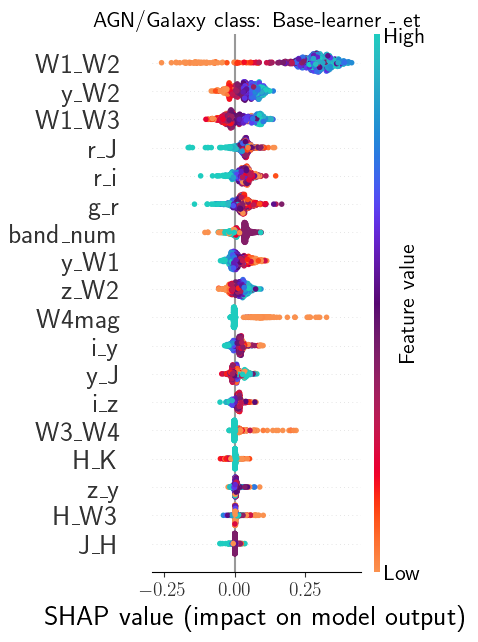

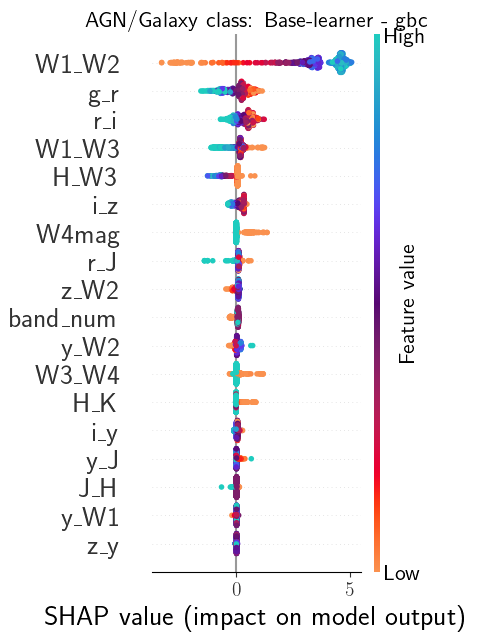

In [117]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        if np.ndim(shap_values_AGN_base[model].values) == 2:
            AGN_ordered_feat_lists[model] = np.argsort(np.sum(np.abs(shap_values_AGN_base[model].values), axis=0))
        if np.ndim(shap_values_AGN_base[model].values) > 2:
            AGN_ordered_feat_lists[model] = np.argsort(np.sum(np.abs(shap_values_AGN_base[model].values[:, :, 1]), axis=0))
        gf.plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model], base_meta='Base', ax_factor=0.5)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_AGN_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [41]:
# new_base_logit_AGN = np.log(gv.cal_AGN_thresh / (1 - gv.cal_AGN_thresh))
new_base_logit_AGN = np.log(0.5 / (1 - 0.5))

In [42]:
idx_list_A = list(full_catalog_df.reset_index().index[highlight_filter_A].to_numpy())
idx_list_B = list(full_catalog_df.reset_index().index[highlight_filter_B].to_numpy())

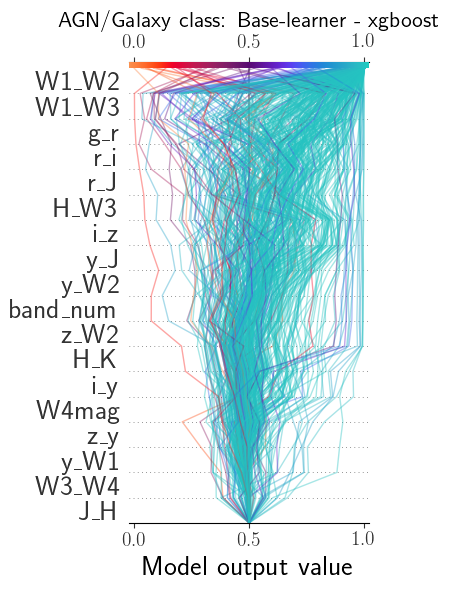

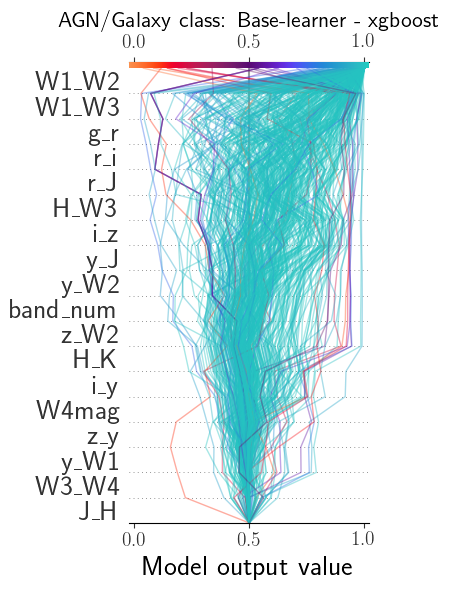

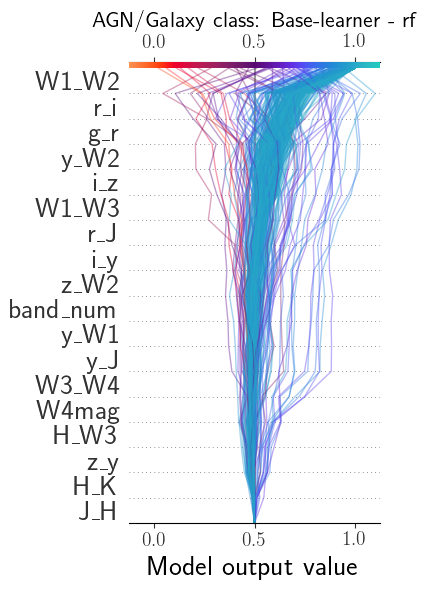

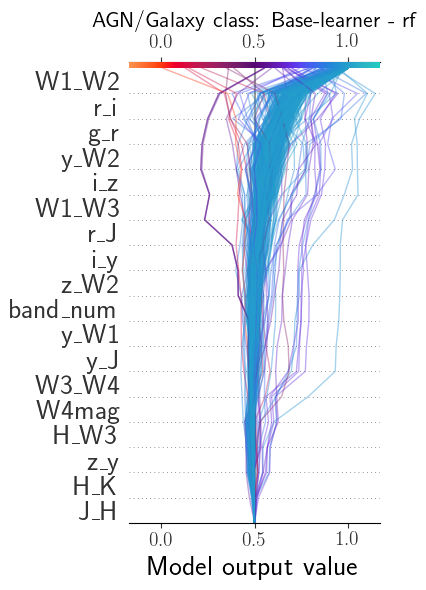

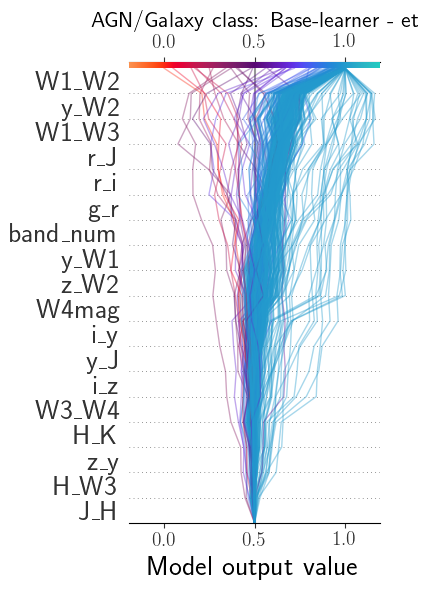

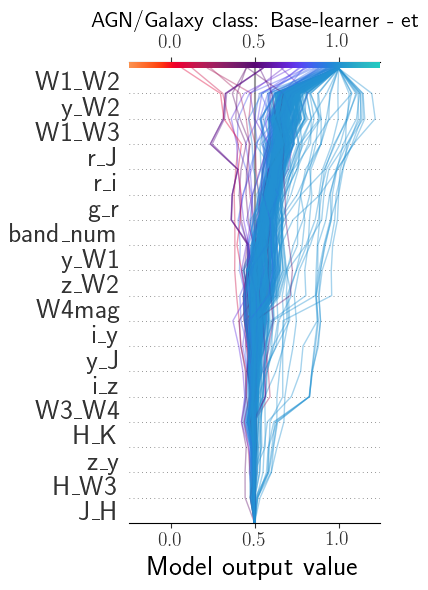

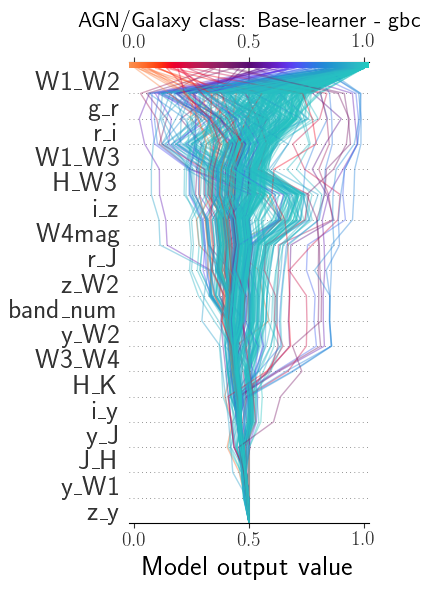

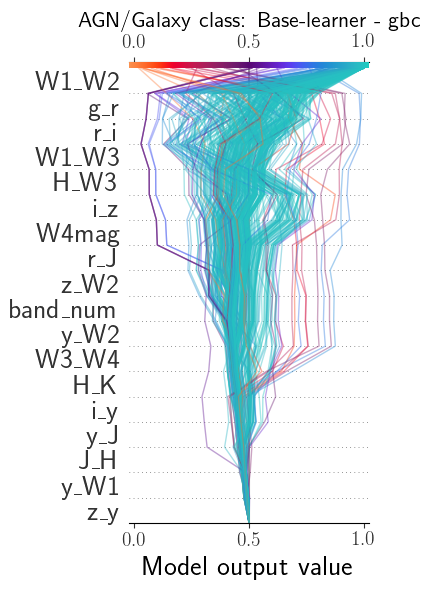

In [119]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        size_side        = 4
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode   = 'logit'
            new_base_AGN = new_base_logit_AGN
        else:
            logit_mode   = 'identity'
            # new_base_AGN = gv.cal_AGN_thresh
            new_base_AGN = 0.5
        for flt_separation in [idx_list_A, idx_list_B]:
            fig              = plt.figure(figsize=(size_side, size_side * 3/2))
            ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
            _ = gf.plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model][flt_separation], 
                                      explainers_AGN_base[model], reduced_cols_AGN, ax1,
                                      logit_mode, new_base_value=new_base_AGN, 
                                      base_meta='Base', highlight=None, feature_order=AGN_ordered_feat_lists[model], alpha=0.4)
            if save_plot_flag:
                plt.savefig(gv.plots_path + f'SHAP_decision_AGN_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
            plt.show()

In [44]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN = gf.mean_abs_SHAP_base_models(shap_values_AGN_base, list(shap_values_AGN_base.keys()))
    for key in shap_values_AGN_base.keys():
        sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_AGN = [(key, name) for key in sorted_mean_abs_SHAP_AGN.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [45]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN_base_full_df = pd.concat([sorted_mean_abs_SHAP_AGN[key].reset_index(drop=True) for key in shap_values_AGN_base.keys()], axis=1)
    sorted_mean_abs_SHAP_AGN_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_AGN)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN_base_full_df)

Mean absolute SHAP values scaled to sum 100


xgboost                      rf                      et                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0      W1_W2        52.617     W1_W2        45.794     W1_W2        42.229   
1      W1_W3         8.376       r_i        10.373      y_W2         7.269   
2        g_r         6.327       g_r        10.252     W1_W3         6.590   
3        r_i         4.487      y_W2         5.151       r_J         5.745   
4        r_J         3.221       i_z         4.575       r_i         5.406   
5       H_W3         3.096     W1_W3         4.293       g_r         4.923   
6        i_z         3.044       r_J         3.423  band_num         4.446   
7        y_J         2.756       i_y         3.327      y_W1         3.815   
8       y_W2         2.489      z_W2         2.510      z_W2         3.674   
9   band_num         2.137  band_num         1.983     W4mag         3.489   
10      z_W2         2.068      y_W1         1.968       i_y         2.702   
11       H_K         1.934       y_J         1.255       y_J         2.311   
12       i_y         1.763     W3_W4         1.233       i_z         2.150   
13     W4mag         1.738     W4mag         1.130     W3_W4         1.840   
14       z_y         1.534      H_W3         0.882       H_K         0.985   
15      y_W1         0.898       z_y         0.825       z_y         0.983   
16     W3_W4         0.781       H_K         0.806      H_W3         0.971   
17       J_H         0.731       J_H         0.221       J_H         0.473   

         gbc                
     Feature Mean_abs_SHAP  
0      W1_W2        62.444  
1        g_r         7.074  
2        r_i         6.553  
3      W1_W3         4.752  
4       H_W3         3.695  
5        i_z         3.582  
6      W4mag         2.116  
7        r_J         1.785  
8       z_W2         1.526  
9   band_num         1.436  
10      y_W2         1.304  
11     W3_W4         1.113  
12       H_K         0.844  
13       i_y         0.629  
14       y_J         0.610  
15       J_H         0.217  
16      y_W1         0.168  
17       z_y         0.153

In [46]:
# if run_shap_AGN_base:
#     sorted_mean_abs_SHAP_AGN = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [47]:
# if run_shap_AGN_base:
#     print('Combined mean absolute SHAP values scaled to sum 100')
#     sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN.copy().set_index('Feature')
#     for key in shap_values_AGN_base.keys():
#         factor = sorted_mean_abs_SHAP_AGN.set_index('Feature').loc[key] / 100
#         tmp_feat_imp = sorted_mean_abs_SHAP_AGN_base_full_df.loc[:, key].copy().set_index('Feature')
#         sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN_comb + tmp_feat_imp * factor
#     sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN_comb.sort_values(by=['Mean_abs_SHAP'],
#                                                                               ascending=False).drop(index=list(shap_values_AGN_base.keys()))
#     sorted_mean_abs_SHAP_AGN_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_AGN_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
#     with pd.option_context('display.float_format', '{:.3f}'.format):
#         display(sorted_mean_abs_SHAP_AGN_comb)

In [48]:
if run_shap_AGN_base:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=base_models_names_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_AGN_base[model].expected_value]).flatten()[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))


xgboost:
1
9.49027

rf:
1
0.42604

et:
1
0.42564

gbc:
1
5.0244


---

#### SHAP - Radio detection model

In [49]:
if run_shap_radio_base:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [50]:
if run_shap_radio_base:
    sample_size_radio   = 1000
    filter_pred_AGN     = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_radio   = len(full_catalog_df)
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 688


In [51]:
if run_shap_radio_base:
    base_models_name_radio   = gf.get_base_estimators_names(radio_det_clf)

In [52]:
if run_shap_radio_base:
    reduced_data_radio    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio.loc[:, ['LOFAR_detect', 'pred_radio']].describe())
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_name_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns.drop(base_models_name_radio)

LOFAR_detect  pred_radio
count    688.000000  688.000000
mean       0.343023    0.001453
std        0.475065    0.038125
min        0.000000    0.000000
25%        0.000000    0.000000
50%        0.000000    0.000000
75%        1.000000    0.000000
max        1.000000    1.000000

Use FastTreeSHAP package

In [53]:
if run_shap_radio_base:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                     n_jobs=12)

In [54]:
if run_shap_radio_base:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=base_models_name_radio))

Working with base model xgboost
Working with base model catboost
Working with base model rf
Working with base model et


In [55]:
if run_shap_radio_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        expected_value = np.array([explainers_radio_base[model].expected_value]).flatten()[-1]
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            print(f'{model: <10}\t: {np.exp(expected_value) / (1 + np.exp(expected_value)): .4f}')
        else:
            print(f'{model: <10}\t: {expected_value: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	:  0.1026
catboost  	:  0.0757
rf        	:  0.1265
et        	:  0.1265


In [120]:
if run_shap_radio_base:
    radio_ordered_feat_lists = {}

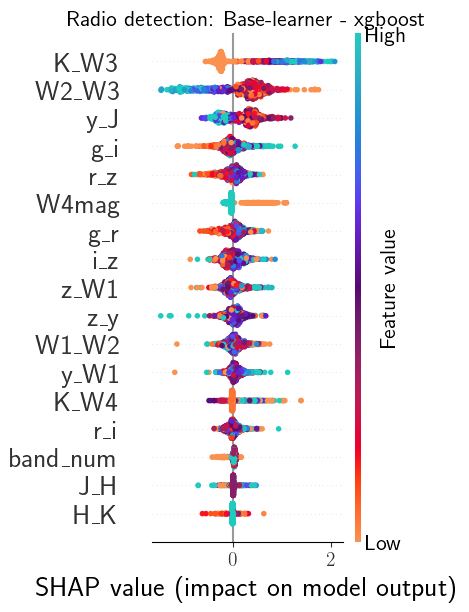

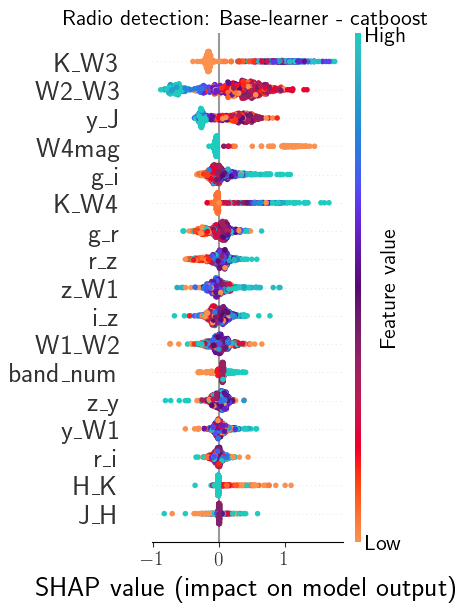

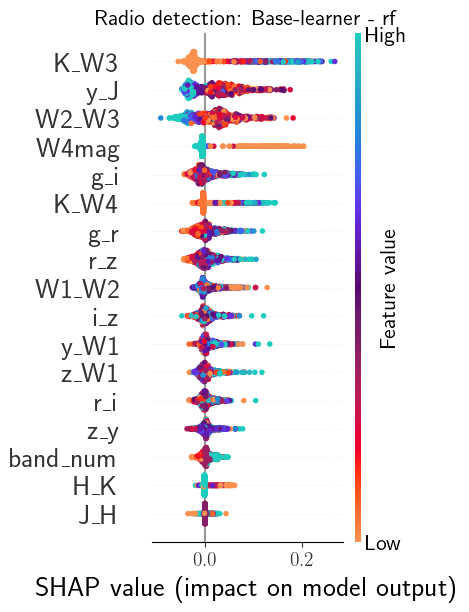

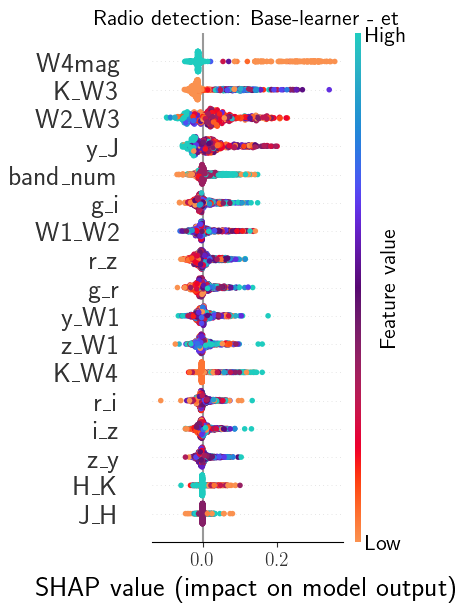

In [121]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        if np.ndim(shap_values_radio_base[model].values) == 2:
            radio_ordered_feat_lists[model] = np.argsort(np.sum(np.abs(shap_values_radio_base[model].values), axis=0))
        if np.ndim(shap_values_radio_base[model].values) > 2:
            radio_ordered_feat_lists[model] = np.argsort(np.sum(np.abs(shap_values_radio_base[model].values[:, :, 1]), axis=0))
        gf.plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model], base_meta='Base', ax_factor=0.5)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_radio_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [57]:
# new_base_logit_radio = np.log(gv.radio_thresh / (1 - gv.radio_thresh))
new_base_logit_radio = np.log(0.5 / (1 - 0.5))

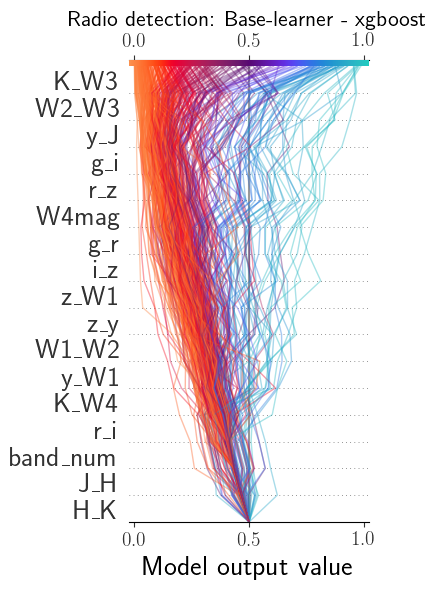

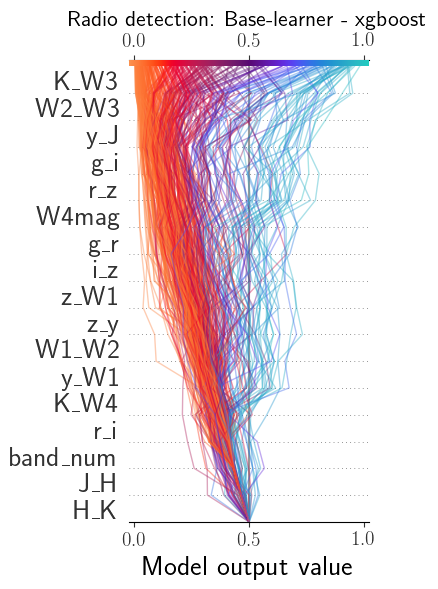

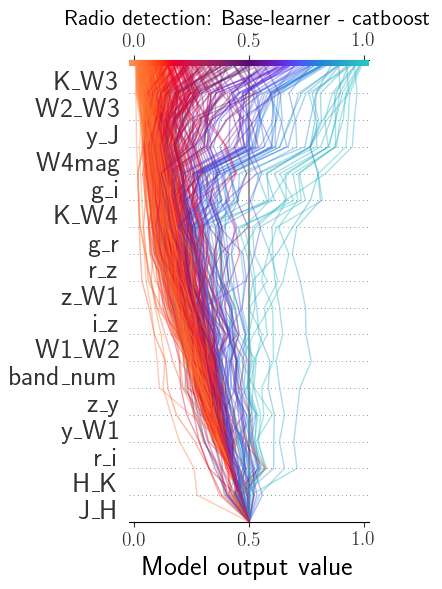

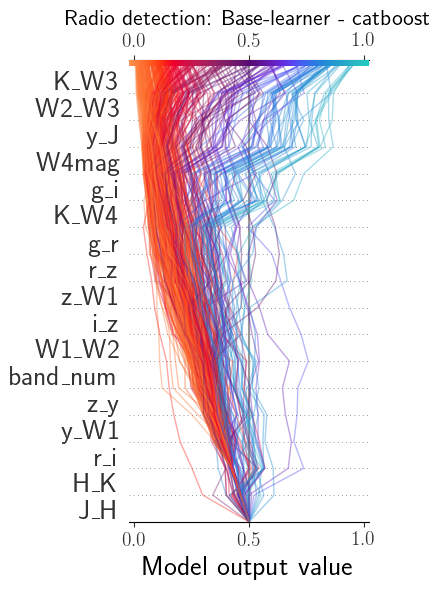

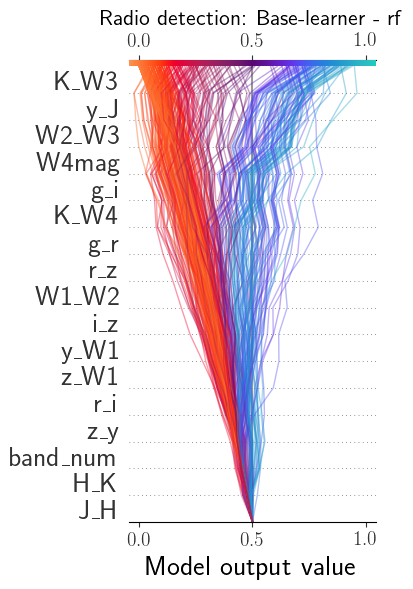

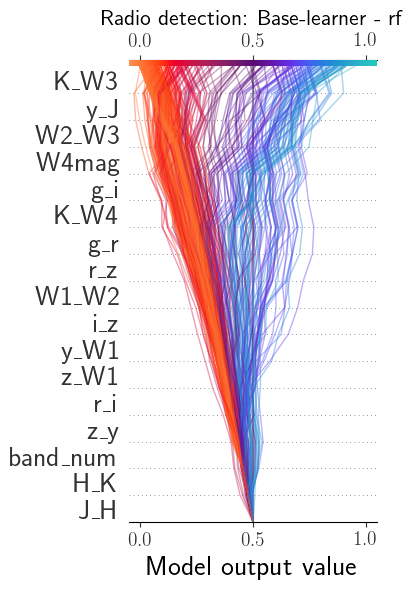

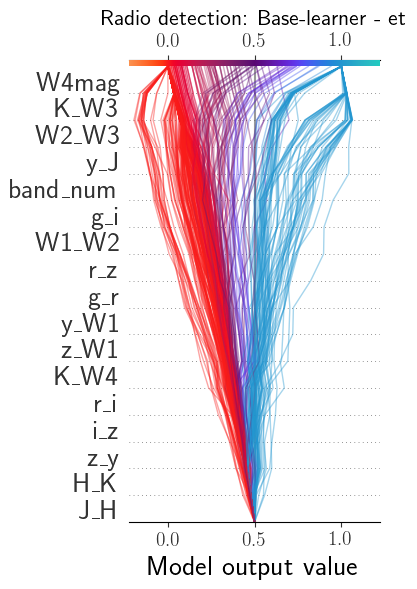

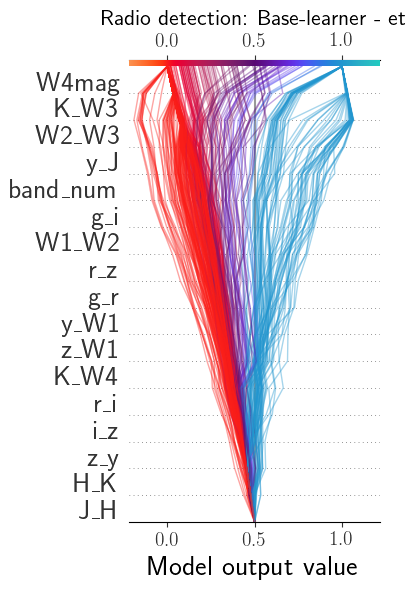

In [122]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        size_side          = 4
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode     = 'logit'
            new_base_radio = new_base_logit_radio
        else:
            logit_mode     = 'identity'
            # new_base_radio = gv.radio_thresh
            new_base_radio = 0.5
        for flt_separation in [idx_list_A, idx_list_B]:
            fig                = plt.figure(figsize=(size_side, size_side * 3/2))
            ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')
            _ = gf.plot_shap_decision('Radio detection', model, shap_values_radio_base[model][flt_separation], 
                                  explainers_radio_base[model], reduced_cols_radio, ax1, logit_mode, 
                                  new_base_value=new_base_radio, base_meta='Base', highlight=None, 
                                      feature_order=radio_ordered_feat_lists[model], alpha=0.4)
            if save_plot_flag:
                plt.savefig(gv.plots_path + f'SHAP_decision_radio_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
            plt.show()

In [60]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio = gf.mean_abs_SHAP_base_models(shap_values_radio_base, list(shap_values_radio_base.keys()))
    for key in shap_values_radio_base.keys():
        sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                  sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_radio = [(key, name) for key in sorted_mean_abs_SHAP_radio.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [61]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio_base_full_df = pd.concat([sorted_mean_abs_SHAP_radio[key].reset_index(drop=True) for key in shap_values_radio_base.keys()], axis=1)
    sorted_mean_abs_SHAP_radio_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_radio)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_base_full_df)

Mean absolute SHAP values scaled to sum 100


xgboost                catboost                      rf                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0       K_W3        18.430      K_W3        17.065      K_W3        19.931   
1      W2_W3        16.977     W2_W3        16.287       y_J        12.006   
2        y_J        10.770       y_J        10.999     W2_W3        11.782   
3        g_i         6.033     W4mag         9.224     W4mag         9.218   
4        r_z         5.459       g_i         5.287       g_i         5.686   
5      W4mag         5.185      K_W4         5.203      K_W4         5.159   
6        g_r         5.069       g_r         4.910       g_r         4.930   
7        i_z         4.937       r_z         4.519       r_z         4.852   
8       z_W1         4.698      z_W1         4.160     W1_W2         4.274   
9        z_y         4.268       i_z         4.036       i_z         3.699   
10     W1_W2         4.190     W1_W2         3.938      y_W1         3.697   
11      y_W1         3.706  band_num         3.218      z_W1         3.589   
12      K_W4         3.321       z_y         3.155       r_i         3.128   
13       r_i         3.095      y_W1         2.770       z_y         2.947   
14  band_num         1.629       r_i         2.160  band_num         2.773   
15       J_H         1.118       H_K         1.988       H_K         1.619   
16       H_K         1.115       J_H         1.080       J_H         0.711   

          et                
     Feature Mean_abs_SHAP  
0      W4mag        15.556  
1       K_W3        12.636  
2      W2_W3        12.120  
3        y_J         8.897  
4   band_num         5.590  
5        g_i         5.185  
6      W1_W2         5.147  
7        r_z         4.776  
8        g_r         4.653  
9       y_W1         4.348  
10      z_W1         4.310  
11      K_W4         3.962  
12       r_i         3.595  
13       i_z         3.382  
14       z_y         3.009  
15       H_K         1.925  
16       J_H         0.909

In [62]:
# if run_shap_radio_base:
#     sorted_mean_abs_SHAP_radio = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_radio_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [63]:
# if run_shap_radio_base:
#     print('Combined mean absolute SHAP values scaled to sum 100')
#     sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio.copy().set_index('Feature')
#     for key in shap_values_radio_base.keys():
#         factor = sorted_mean_abs_SHAP_radio.set_index('Feature').loc[key] / 100
#         tmp_feat_imp = sorted_mean_abs_SHAP_radio_base_full_df.loc[:, key].copy().set_index('Feature')
#         sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio_comb + tmp_feat_imp * factor
#     sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio_comb.sort_values(by=['Mean_abs_SHAP'],
#                                                                                   ascending=False).drop(index=list(shap_values_radio_base.keys()))
#     sorted_mean_abs_SHAP_radio_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_radio_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
#     with pd.option_context('display.float_format', '{:.3f}'.format):
#         display(sorted_mean_abs_SHAP_radio_comb)

In [64]:
if run_shap_radio_base:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=base_models_name_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_radio_base[model].expected_value]).flatten()[-1] + shap_values_radio_base[model].values[0].sum()).round(5))


xgboost:
1
0.26095

catboost:
0
-0.50206

rf:
1
0.12652

et:
1
0.12648


---

#### SHAP - First redshift prediction model

In [65]:
if run_shap_z_base:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [66]:
if run_shap_z_base:
    sample_size_z        = 1000
    filter_pred_rAGN     = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
    sample_size_z        = np.nanmin([sample_size_z, np.sum(filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 236


In [67]:
if run_shap_z_base:
    base_models_name_z = gf.get_base_estimators_names(redshift_reg)

In [68]:
if run_shap_z_base:
    reduced_data_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_z, random_state=gv.seed).copy()
    display(reduced_data_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_name_z)
    reduced_cols_z    = reduced_data_z_df.columns.drop(base_models_name_z)

Z      pred_Z
count  236.000000  236.000000
mean     1.161144    1.286614
std      0.812500    0.812695
min      0.002000    0.010000
25%      0.490500    0.622250
50%      1.065500    1.198500
75%      1.660000    1.840250
max      4.326000    4.047000

Use FastTreeSHAP package

In [69]:
if run_shap_z_base:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                 n_jobs=12)

In [70]:
if run_shap_z_base:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=base_models_name_z))

Working with base model rf
Working with base model catboost
Working with base model xgboost
Working with base model gbr


In [71]:
if run_shap_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
rf        	:  1.3230
catboost  	:  1.3233
xgboost   	:  1.3233
gbr       	:  1.3233


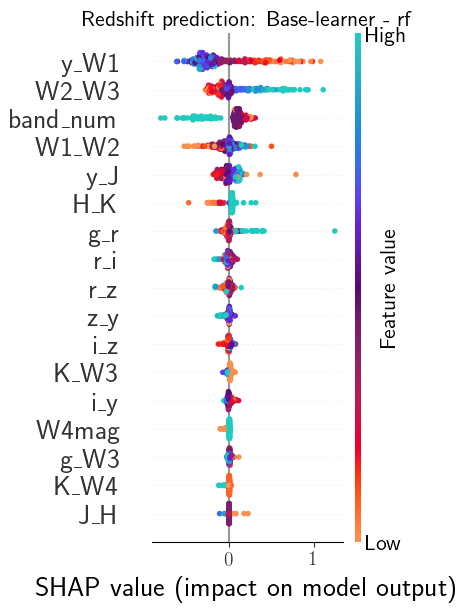

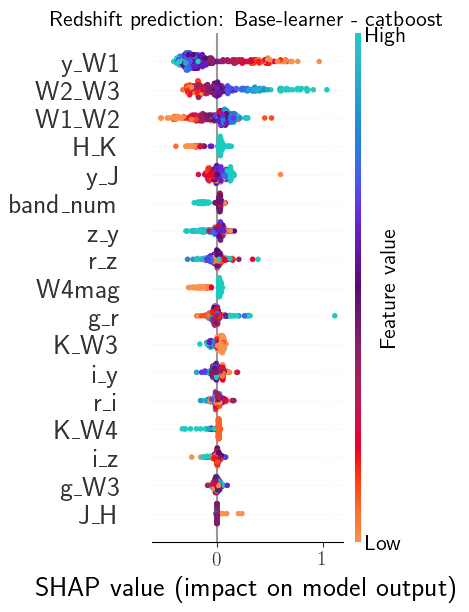

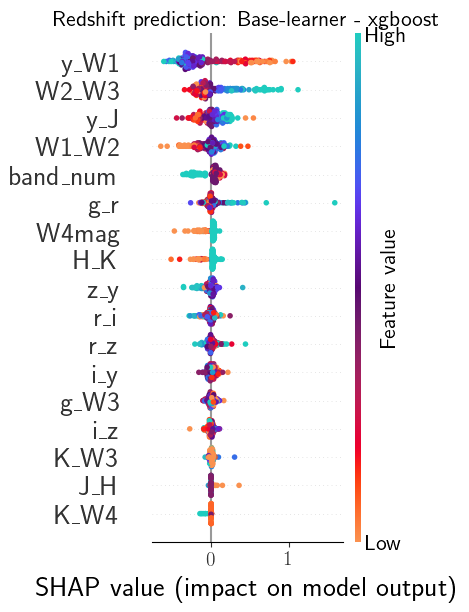

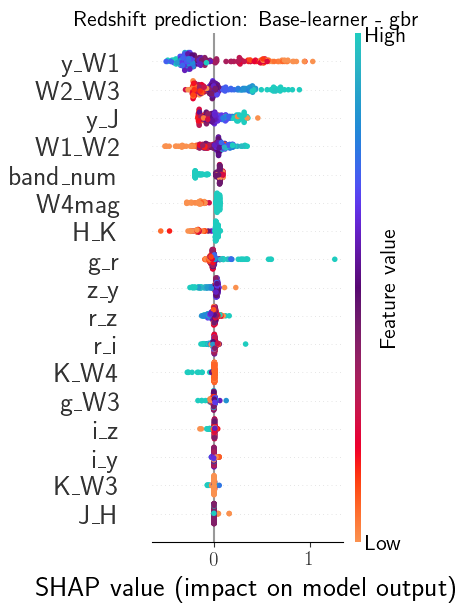

In [82]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        gf.plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model], base_meta='Base', ax_factor=0.5)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

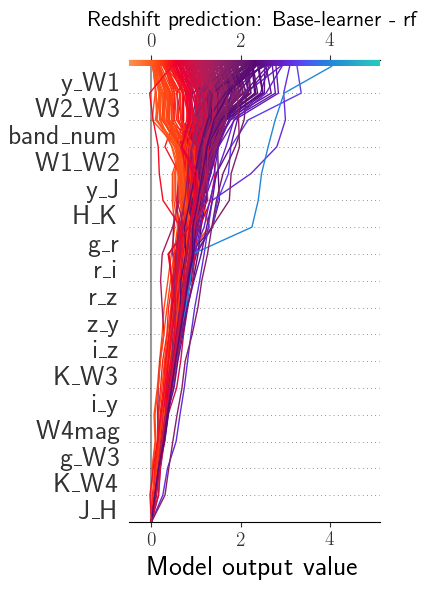

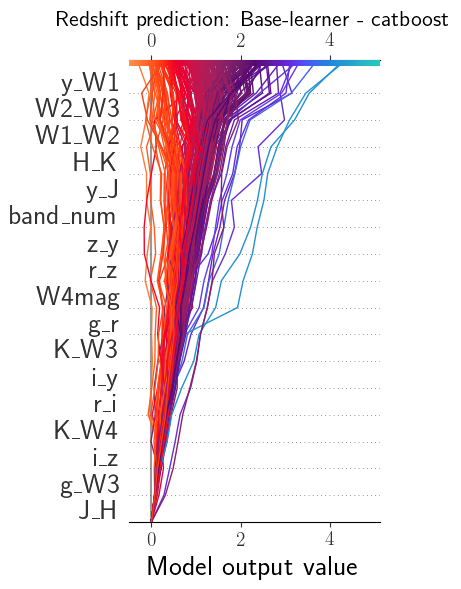

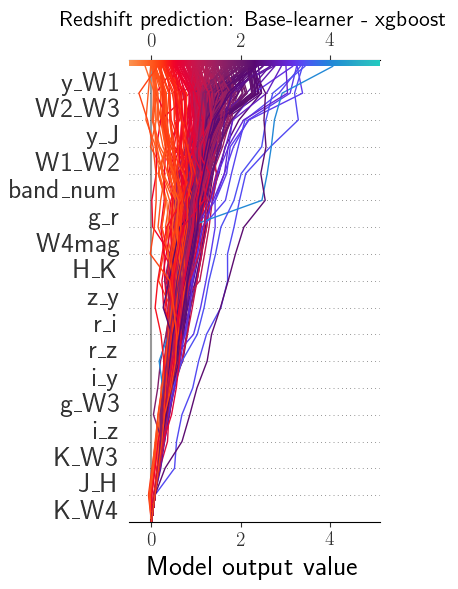

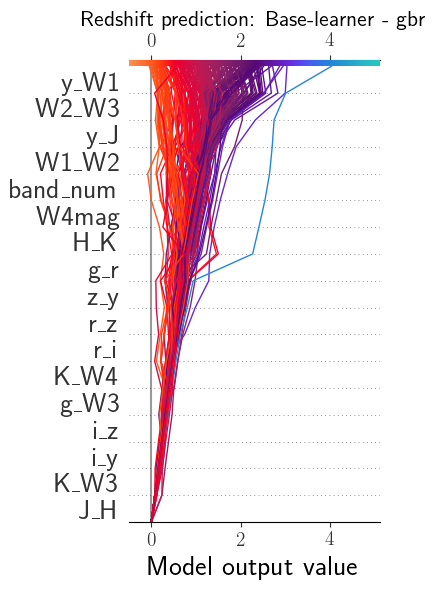

In [81]:
if run_shap_z_base:
    xlims_plt_z         = (-0.5, full_catalog_df.loc[reduced_data_z_df.index, ['Z', 'pred_Z']].max().max() + 0.8)
    for model in shap_values_z_base.keys():
        size_side       = 4
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model],\
                                  reduced_cols_z, ax1, 'identity', new_base_value=0.0, base_meta='Base', xlim=xlims_plt_z)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [74]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z = gf.mean_abs_SHAP_base_models(shap_values_z_base, list(shap_values_z_base.keys()))
    for key in shap_values_z_base.keys():
        sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'] /\
                                                              sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_z = [(key, name) for key in sorted_mean_abs_SHAP_z.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [75]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z_base_full_df = pd.concat([sorted_mean_abs_SHAP_z[key].reset_index(drop=True) for key in shap_values_z_base.keys()], axis=1)
    sorted_mean_abs_SHAP_z_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_z)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_base_full_df)

Mean absolute SHAP values scaled to sum 100


rf                catboost                 xgboost                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0       y_W1        28.362      y_W1        23.035      y_W1        25.453   
1      W2_W3        16.283     W2_W3        17.923     W2_W3        14.957   
2   band_num        15.592     W1_W2        11.494       y_J         9.384   
3      W1_W2         9.121       H_K         5.663     W1_W2         9.194   
4        y_J         6.467       y_J         5.273  band_num         7.815   
5        H_K         5.440  band_num         4.571       g_r         4.919   
6        g_r         4.209       z_y         4.430     W4mag         4.327   
7        r_i         2.425       r_z         4.250       H_K         4.181   
8        r_z         2.357     W4mag         4.172       z_y         3.838   
9        z_y         1.719       g_r         3.839       r_i         3.358   
10       i_z         1.547      K_W3         3.469       r_z         3.234   
11      K_W3         1.534       i_y         3.017       i_y         2.997   
12       i_y         1.517       r_i         2.546      g_W3         2.182   
13     W4mag         1.031      K_W4         2.425       i_z         2.020   
14      g_W3         1.028       i_z         1.908      K_W3         1.340   
15      K_W4         0.826      g_W3         1.592       J_H         0.402   
16       J_H         0.542       J_H         0.392      K_W4         0.396   

         gbr                
     Feature Mean_abs_SHAP  
0       y_W1        28.496  
1      W2_W3        16.395  
2        y_J        10.517  
3      W1_W2        10.110  
4   band_num         7.131  
5      W4mag         5.935  
6        H_K         4.936  
7        g_r         4.426  
8        z_y         4.034  
9        r_z         2.303  
10       r_i         1.413  
11      K_W4         1.098  
12      g_W3         1.049  
13       i_z         1.037  
14       i_y         0.410  
15      K_W3         0.406  
16       J_H         0.304

In [76]:
# if run_shap_z_base:
#     sorted_mean_abs_SHAP_z = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [77]:
# if run_shap_z_base:
#     print('Combined mean absolute SHAP values scaled to sum 100')
#     sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z.copy().set_index('Feature')
#     for key in shap_values_z_base.keys():
#         factor = sorted_mean_abs_SHAP_z.set_index('Feature').loc[key] / 100
#         tmp_feat_imp = sorted_mean_abs_SHAP_z_base_full_df.loc[:, key].copy().set_index('Feature')
#         sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z_comb + tmp_feat_imp * factor
#     sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z_comb.sort_values(by=['Mean_abs_SHAP'],
#                                                                               ascending=False).drop(index=list(shap_values_z_base.keys()))
#     sorted_mean_abs_SHAP_z_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_z_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
#     with pd.option_context('display.float_format', '{:.3f}'.format):
#         display(sorted_mean_abs_SHAP_z_comb)

In [78]:
if run_shap_z_base:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=base_models_name_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))


rf:
1.10523
1.10523

catboost:
1.16073
1.16073

xgboost:
1.22707
1.22707

gbr:
1.27069
1.27069


---